<div>

> **Note**
>
> Code chunks run Python commands unless it starts with `%%bash`, in
> which case, those chunks run shell commands.

</div>

In this tutorial we will look at different ways of integrating multiple
single cell RNA-seq datasets. We will explore a few different methods to
correct for batch effects across datasets. Seurat uses the data
integration method presented in Comprehensive Integration of Single Cell
Data, while Scran and Scanpy use a mutual Nearest neighbour method
(MNN). Below you can find a list of some methods for single data
integration:

  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  Markdown          Language          Library           Ref
  ----------------- ----------------- ----------------- -----------------------------------------------------------------------------------------------------------------------------------
  CCA               R                 Seurat            [Cell](https://www.sciencedirect.com/science/article/pii/S0092867419305598?via%3Dihub)

  MNN               R/Python          Scater/Scanpy     [Nat. Biotech.](https://www.nature.com/articles/nbt.4091)

  Conos             R                 conos             [Nat.
                                                        Methods](https://www.nature.com/articles/s41592-019-0466-z?error=cookies_not_supported&code=5680289b-6edb-40ad-9934-415dac4fdb2f)

  Scanorama         Python            scanorama         [Nat. Biotech.](https://www.nature.com/articles/s41587-019-0113-3)
  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Data preparation

Let's first load necessary libraries and the data saved in the previous
lab.

In [28]:
#| label: libraries
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import warnings
import os
import subprocess

warnings.simplefilter(action='ignore', category=Warning)

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 3             

sc.settings.set_figure_params(dpi=80)
%matplotlib inline

Create individual **adata** objects per batch.

In [29]:
#| label: fetch-data
# download pre-computed data if missing or long compute
fetch_data = True

# url for source and intermediate data
path_data = "https://nextcloud.dc.scilifelab.se/public.php/webdav"
curl_upass = "zbC5fr2LbEZ9rSE:scRNAseq2025"


path_results = "data/covid/results"
if not os.path.exists(path_results):
    os.makedirs(path_results, exist_ok=True)

path_file = "data/covid/results/scanpy_covid_qc_dr.h5ad"
if fetch_data and not os.path.exists(path_file):
    file_url = os.path.join(path_data, "covid/results_scanpy/scanpy_covid_qc_dr.h5ad")
    subprocess.call(["curl", "-u", curl_upass, "-o", path_file, file_url ])

adata = sc.read_h5ad(path_file)
adata

AnnData object with n_obs × n_vars = 7332 × 2656
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'n_genes', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'doublet_scores', 'predicted_doublets', 'doublet_info'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'doublet_info_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'phase_colors', 'sample_colors', 'tsne', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [30]:
#| label: check-data
print(adata.X.shape)

(7332, 2656)


As the stored AnnData object contains scaled data based on variable
genes, we need to make a new object with the logtransformed normalized
counts. The new variable gene selection should not be performed on the
scaled data matrix.

In [31]:
#| label: from-raw

# First store the old set of hvgs
var_genes_all = adata.var.highly_variable
print("Highly variable genes: %d"%sum(var_genes_all))

adata = adata.raw.to_adata() 

# in some versions of Anndata there is an issue with information on the logtransformation in the slot log1p.base so we set it to None to not get errors.
adata.uns['log1p']['base']=None

# check that the matrix looks like normalized counts
print(adata.X[1:10,1:10])

Highly variable genes: 2656
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (9, 9)>
  Coords	Values
  (0, 3)	1.479703103222477
  (7, 6)	1.6397408237842532


## Detect variable genes

Variable genes can be detected across the full dataset, but then we run
the risk of getting many batch-specific genes that will drive a lot of
the variation. Or we can select variable genes from each batch
separately to get only celltype variation. In the dimensionality
reduction exercise, we already selected variable genes, so they are
already stored in `adata.var.highly_variable`.

Detect variable genes in each dataset separately using the `batch_key`
parameter.

In [32]:
#| label: hvg2
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'sample')

print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata.var.highly_variable_nbatches > 0

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
Highly variable genes intersection: 83
Number of batches where gene is variable:
highly_variable_nbatches
0    6760
1    5164
2    3560
3    2050
4    1003
5     487
6     228
7     133
8      83
Name: count, dtype: int64


Compare overlap of variable genes with batches or with all data.

In [33]:
#| label: hvg3
print("Any batch var genes: %d"%sum(var_genes_batch))
print("All data var genes: %d"%sum(var_genes_all))
print("Overlap: %d"%sum(var_genes_batch & var_genes_all))
print("Variable genes in all batches: %d"%sum(adata.var.highly_variable_nbatches == 6))
print("Overlap batch instersection and all: %d"%sum(var_genes_all & adata.var.highly_variable_intersection))

Any batch var genes: 12708
All data var genes: 2656
Overlap: 2654
Variable genes in all batches: 228
Overlap batch instersection and all: 83


<div>

> **Discuss**
>
> Did you understand the difference between running variable gene
> selection per dataset and combining them vs running it on all samples
> together. Can you think of any situation where it would be best to run
> it on all samples and a situation where it should be done by batch?

</div>

Select all genes that are variable in at least 2 datasets and use for
remaining analysis.

In [34]:
#| label: hvg4
var_select = adata.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

3984

Run scaling and pca with that set of genes.

In [35]:
#| label: hvg5

# first store again the full matrix to the raw slot.
adata.raw = adata
adata = adata[:,var_genes]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    with n_comps=50
    finished (0:00:00)


Before running integrations and new dimensionality reduction, lets save
the old Umap and tSNE into a new slot in `obsm`.

In [36]:
#| label: save-raw
adata.obsm['X_umap_uncorr'] = adata.obsm['X_umap']
adata.obsm['X_tsne_uncorr'] = adata.obsm['X_tsne']

## BBKNN

First, we will run BBKNN, it takes the anndata object and calculates a
knn graph that is batch balanced. We can then use that graph to run
Umap, tSNE and/or clustering.

In [37]:
#| label: bbknn
sc.external.pp.bbknn(adata, 'sample')

sc.tl.umap(adata)
sc.tl.tsne(adata)

# save new umap/tsne to new slots in obsm
adata.obsm['X_umap_bbknn'] = adata.obsm['X_umap']
adata.obsm['X_tsne_bbknn'] = adata.obsm['X_tsne']

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:01)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:11)


We can now plot the unintegrated and the integrated space reduced
dimensions.

In [38]:
#| label: plot-bbknn
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.embedding(adata, "X_umap_uncorr",color="sample", title="Uncorrected umap", ax=axs[0,0], show=False)
sc.pl.embedding(adata, "X_tsne_uncorr",color="sample", title="Uncorrected tsne", ax=axs[0,1], show=False)
sc.pl.embedding(adata, "X_umap_bbknn",color="sample", title="BBKNN Corrected umap", ax=axs[1,0], show=False)
sc.pl.embedding(adata, "X_tsne_bbknn",color="sample", title="BBKNN Corrected tsne", ax=axs[1,1], show=False)

<Axes: title={'center': 'BBKNN Corrected tsne'}, xlabel='X_tsne_bbknn1', ylabel='X_tsne_bbknn2'>

Let's save the integrated data for further analysis.

In [39]:
#| label: save-bbknn

save_file = './data/covid/results/scanpy_covid_qc_dr_bbknn.h5ad'
adata.write_h5ad(save_file)

## Harmony

An alternative method for integration is Harmony, for more details on
the method, please se their paper [Nat.
Methods](https://www.nature.com/articles/s41592-019-0619-0). This method
runs the integration on a dimensionality reduction, in most applications
the PCA.

In [40]:
#| label: harmony
import scanpy.external as sce 
import harmonypy as hm 

In [41]:
sce.pp.harmony_integrate(adata, 'sample')

# Then we calculate a new umap and tsne.
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30, use_rep='X_pca_harmony')
sc.tl.umap(adata)
sc.tl.tsne(adata, use_rep='X_pca_harmony')
sc.tl.leiden(adata, resolution=0.5)

2025-05-15 20:38:55,016 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-05-15 20:38:55,635 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-05-15 20:38:55,665 - harmonypy - INFO - Iteration 1 of 10
2025-05-15 20:38:56,086 - harmonypy - INFO - Iteration 2 of 10
2025-05-15 20:38:56,463 - harmonypy - INFO - Iteration 3 of 10
2025-05-15 20:38:56,835 - harmonypy - INFO - Iteration 4 of 10
2025-05-15 20:38:57,192 - harmonypy - INFO - Iteration 5 of 10
2025-05-15 20:38:57,564 - harmonypy - INFO - Converged after 5 iterations


computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:04)
computing tSNE
    using sklearn.manifold.TSNE
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm)
    'tsne', tSNE parameters (adata.uns) (0:00:11)
running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


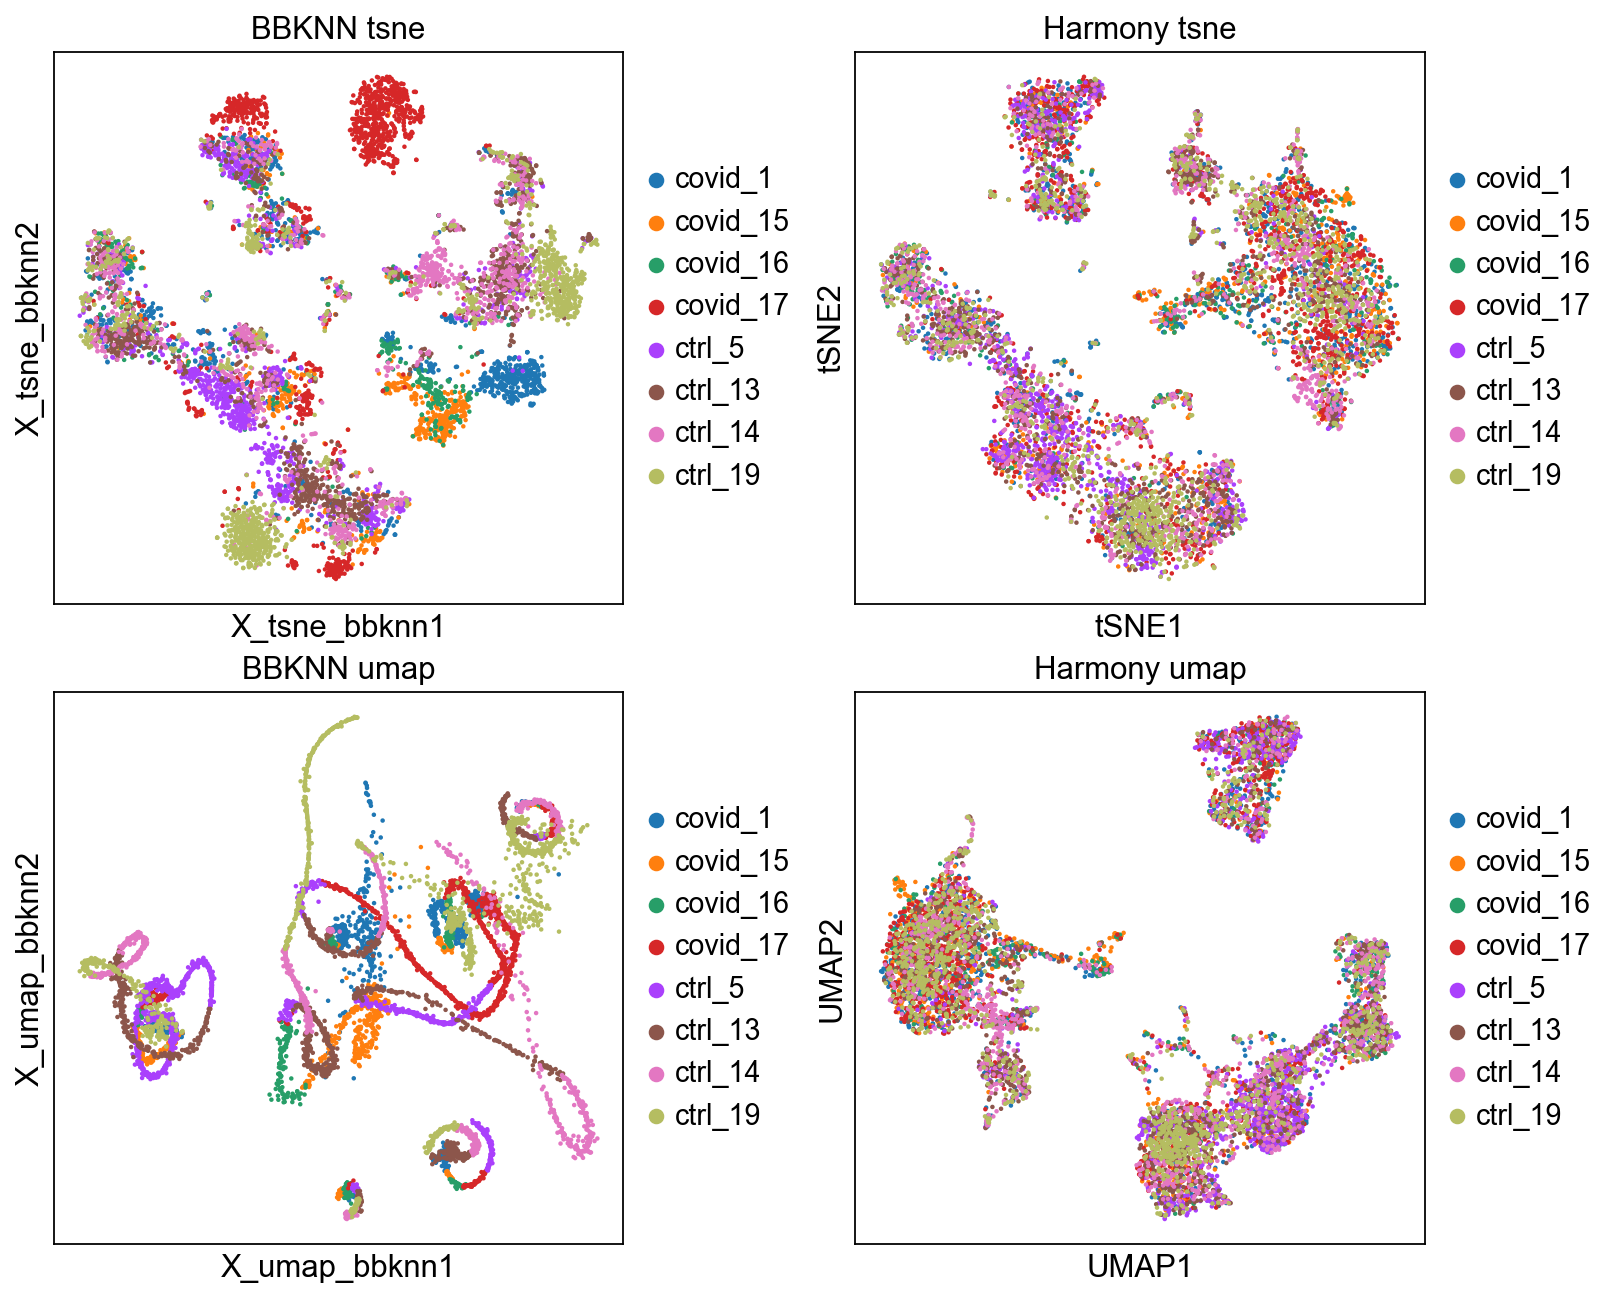

In [45]:
#| label: plot-harmony
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.embedding(adata, 'X_tsne_bbknn', color="sample", title="BBKNN tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="sample", title="Harmony tsne", ax=axs[0,1], show=False)
sc.pl.embedding(adata, 'X_umap_bbknn', color="sample", title="BBKNN umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Harmony umap", ax=axs[1,1], show=False)
fig

Let's save the integrated data for further analysis.

In [46]:
#| label: save-harmony
# Store this umap and tsne with a new name.
adata.obsm['X_umap_harmony'] = adata.obsm['X_umap']
adata.obsm['X_tsne_harmony'] = adata.obsm['X_tsne']

#save to file
save_file = './data/covid/results/scanpy_covid_qc_dr_harmony.h5ad'
adata.write_h5ad(save_file)

## Combat

Batch correction can also be performed with combat. Note that ComBat
batch correction requires a dense matrix format as input (which is
already the case in this example).

In [ ]:
#| label: combat
# create a new object with lognormalized counts
adata_combat = sc.AnnData(X=adata.raw.X, var=adata.raw.var, obs = adata.obs)

# first store the raw data 
adata_combat.raw = adata_combat

# run combat
sc.pp.combat(adata_combat, key='sample')

Then we run the regular steps of dimensionality reduction on the combat
corrected data. Variable gene selection, pca and umap with combat data.

In [ ]:
#| label: process-combat
sc.pp.highly_variable_genes(adata_combat)
print("Highly variable genes: %d"%sum(adata_combat.var.highly_variable))
sc.pl.highly_variable_genes(adata_combat)

sc.pp.pca(adata_combat, n_comps=30, use_highly_variable=True, svd_solver='arpack')

sc.pp.neighbors(adata_combat)

sc.tl.umap(adata_combat)
sc.tl.tsne(adata_combat)

In [ ]:
#| label: hvg-combat
# compare var_genes
var_genes_combat = adata_combat.var.highly_variable
print("With all data %d"%sum(var_genes_all))
print("With combat %d"%sum(var_genes_combat))
print("Overlap %d"%sum(var_genes_all & var_genes_combat))

print("With 2 batches %d"%sum(var_select))
print("Overlap %d"%sum(var_genes_combat & var_select))

We can now plot the unintegrated and the integrated space reduced
dimensions.

In [ ]:
#| label: plot-combat
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.tsne(adata, color="sample", title="Harmony tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata_combat, color="sample", title="Combat tsne", ax=axs[0,1], show=False)
sc.pl.umap(adata, color="sample", title="Harmony umap", ax=axs[1,0], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat umap", ax=axs[1,1], show=False)

Let's save the integrated data for further analysis.

In [ ]:
#| label: save-combat

# Add the dimred to the other adata object
adata.obsm['X_umap_combat'] = adata_combat.obsm['X_umap']
adata.obsm['X_tsne_combat'] = adata_combat.obsm['X_tsne']
adata.obsm['X_pca_combat'] = adata_combat.obsm['X_pca']

#save to file
save_file = './data/covid/results/scanpy_covid_qc_dr_combat.h5ad'
adata_combat.write_h5ad(save_file)

## Scanorama

Try out [Scanorama](https://github.com/brianhie/scanorama) for data
integration as well. First we need to create individual AnnData objects
from each of the datasets.

*OBS!* There is a function `sc.external.pp.scanorama_integrate`
implemented in the scanpy toolkit. However, it runs scanorama on the PCA
embedding and does not give us nice results when we have tested it, so
we are not using it here.

In [ ]:
#| label: prep-scanorama
# split per batch into new objects.
batches = adata.obs['sample'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['sample'] == batch,]

alldata   

In [ ]:
#| label: scanorama
import scanorama

#subset the individual dataset to the variable genes we defined at the beginning
alldata2 = dict()
for ds in alldata.keys():
    print(ds)
    alldata2[ds] = alldata[ds][:,var_genes]

#convert to list of AnnData objects
adatas = list(alldata2.values())

# run scanorama.integrate
scanorama.integrate_scanpy(adatas, dimred = 50)

In [ ]:
#| label: scanorama-output
#scanorama adds the corrected matrix to adata.obsm in each of the datasets in adatas.
adatas[0].obsm['X_scanorama'].shape

In [ ]:
#| label: scanorama-merge
# Get all the integrated matrices.
scanorama_int = [ad.obsm['X_scanorama'] for ad in adatas]

# make into one matrix.
all_s = np.concatenate(scanorama_int)
print(all_s.shape)

# add to the AnnData object, create a new object first
adata.obsm["Scanorama"] = all_s

In [ ]:
#| label: process-scanorama
# tsne and umap
sc.pp.neighbors(adata, n_pcs =30, use_rep = "Scanorama")
sc.tl.umap(adata)
sc.tl.tsne(adata, n_pcs = 30, use_rep = "Scanorama")

We can now plot the unintegrated and the integrated space reduced
dimensions.

In [ ]:
#| label: plot-scanorama
fig, axs = plt.subplots(2, 2, figsize=(10,8),constrained_layout=True)
sc.pl.embedding(adata, 'X_tsne_harmony', color="sample", title="Harmony tsne", ax=axs[0,0], show=False)
sc.pl.tsne(adata, color="sample", title="Scanorama tsne", ax=axs[0,1], show=False)
sc.pl.embedding(adata, 'X_umap_harmony', color="sample", title="Harmony umap", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Scanorama umap", ax=axs[1,1], show=False)

Let's save the integrated data for further analysis.

In [ ]:
#| label: save-scanorama
# Store this umap and tsne with a new name.
adata.obsm['X_umap_scanorama'] = adata.obsm['X_umap']
adata.obsm['X_tsne_scanorama'] = adata.obsm['X_tsne']

#save to file, now contains all integrations except the combat one.
save_file = './data/covid/results/scanpy_covid_qc_dr_int.h5ad'
adata.write_h5ad(save_file)

## Overview all methods

Now we will plot UMAPS with all three integration methods side by side.

In [ ]:
#| label: plot-all
fig, axs = plt.subplots(2, 3, figsize=(10,8),constrained_layout=True)
sc.pl.embedding(adata, 'X_umap_uncorr', color="sample", title="Uncorrected", ax=axs[0,0], show=False)
sc.pl.embedding(adata, 'X_umap_bbknn', color="sample", title="BBKNN", ax=axs[0,1], show=False)
sc.pl.umap(adata_combat, color="sample", title="Combat", ax=axs[0,2], show=False)
sc.pl.embedding(adata, 'X_umap_harmony', color="sample", title="Harmony", ax=axs[1,0], show=False)
sc.pl.umap(adata, color="sample", title="Scanorama", ax=axs[1,1], show=False)

<div>

> **Discuss**
>
> Look at the different integration results, which one do you think
> looks the best? How would you motivate selecting one method over the
> other? How do you think you could best evaluate if the integration
> worked well?

</div>

## Extra task

Have a look at the documentation for
[BBKNN](https://scanpy.readthedocs.io/en/latest/generated/scanpy.external.pp.bbknn.html#scanpy-external-pp-bbknn)

Try changing some of the parameteres in BBKNN, such as distance metric,
number of PCs and number of neighbors. How does the results change with
different parameters? Can you explain why?

## Session info

```{=html}
<details>
```
```{=html}
<summary>
```
Click here
```{=html}
</summary>
```

In [ ]:
#| label: session
sc.logging.print_versions()

```{=html}
</details>
```